In [21]:
import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler, ConcatDataset
from torch import nn, optim
import torch 
import copy
from sklearn.model_selection import train_test_split

from torchvision import transforms, datasets
import timm 
import timm.optim
from timm.data.transforms_factory import create_transform
from torch.optim import lr_scheduler
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [25]:
train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
   
])

train_transform2 = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(300, 500)),
    transforms.ToTensor(),
   
])

train_transformOriginal = transforms.Compose([transforms.ToTensor()])

dtOri = datasets.ImageFolder(
    root="asl_dataset",
    transform=train_transformOriginal
)

dt1 = datasets.ImageFolder(
    root="asl_dataset",
    transform=train_transform
)

dt2 = datasets.ImageFolder(
    root="asl_dataset",
    transform=train_transform2
)

dtConcat = ConcatDataset([dtOri, dt1, dt2])

print(dtOri.class_to_idx)
print(dtConcat)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35}


In [23]:
idx_to_class = {v: k for k, v in dt.class_to_idx.items()}

def get_class_distribution(dataset):
    count_dict = {k:0 for k,v in dt.class_to_idx.items()} # initialise dictionary
    
    for input, label in dataset:
        label = idx_to_class[label]
        count_dict[label] += 1
            
    return count_dict

print("Distribution of classes: ", get_class_distribution(dt))

get_class_distribution(dt)

Distribution of classes:  {'0': 70, '1': 70, '2': 70, '3': 70, '4': 70, '5': 70, '6': 70, '7': 70, '8': 70, '9': 70, 'a': 70, 'b': 70, 'c': 70, 'd': 70, 'e': 70, 'f': 70, 'g': 70, 'h': 70, 'i': 70, 'j': 70, 'k': 70, 'l': 70, 'm': 70, 'n': 70, 'o': 70, 'p': 70, 'q': 70, 'r': 70, 's': 70, 't': 65, 'u': 70, 'v': 70, 'w': 70, 'x': 70, 'y': 70, 'z': 70}


{'0': 70,
 '1': 70,
 '2': 70,
 '3': 70,
 '4': 70,
 '5': 70,
 '6': 70,
 '7': 70,
 '8': 70,
 '9': 70,
 'a': 70,
 'b': 70,
 'c': 70,
 'd': 70,
 'e': 70,
 'f': 70,
 'g': 70,
 'h': 70,
 'i': 70,
 'j': 70,
 'k': 70,
 'l': 70,
 'm': 70,
 'n': 70,
 'o': 70,
 'p': 70,
 'q': 70,
 'r': 70,
 's': 70,
 't': 65,
 'u': 70,
 'v': 70,
 'w': 70,
 'x': 70,
 'y': 70,
 'z': 70}

Text(0.5, 1.0, 'Class Distribution of the ASL static Dataset')

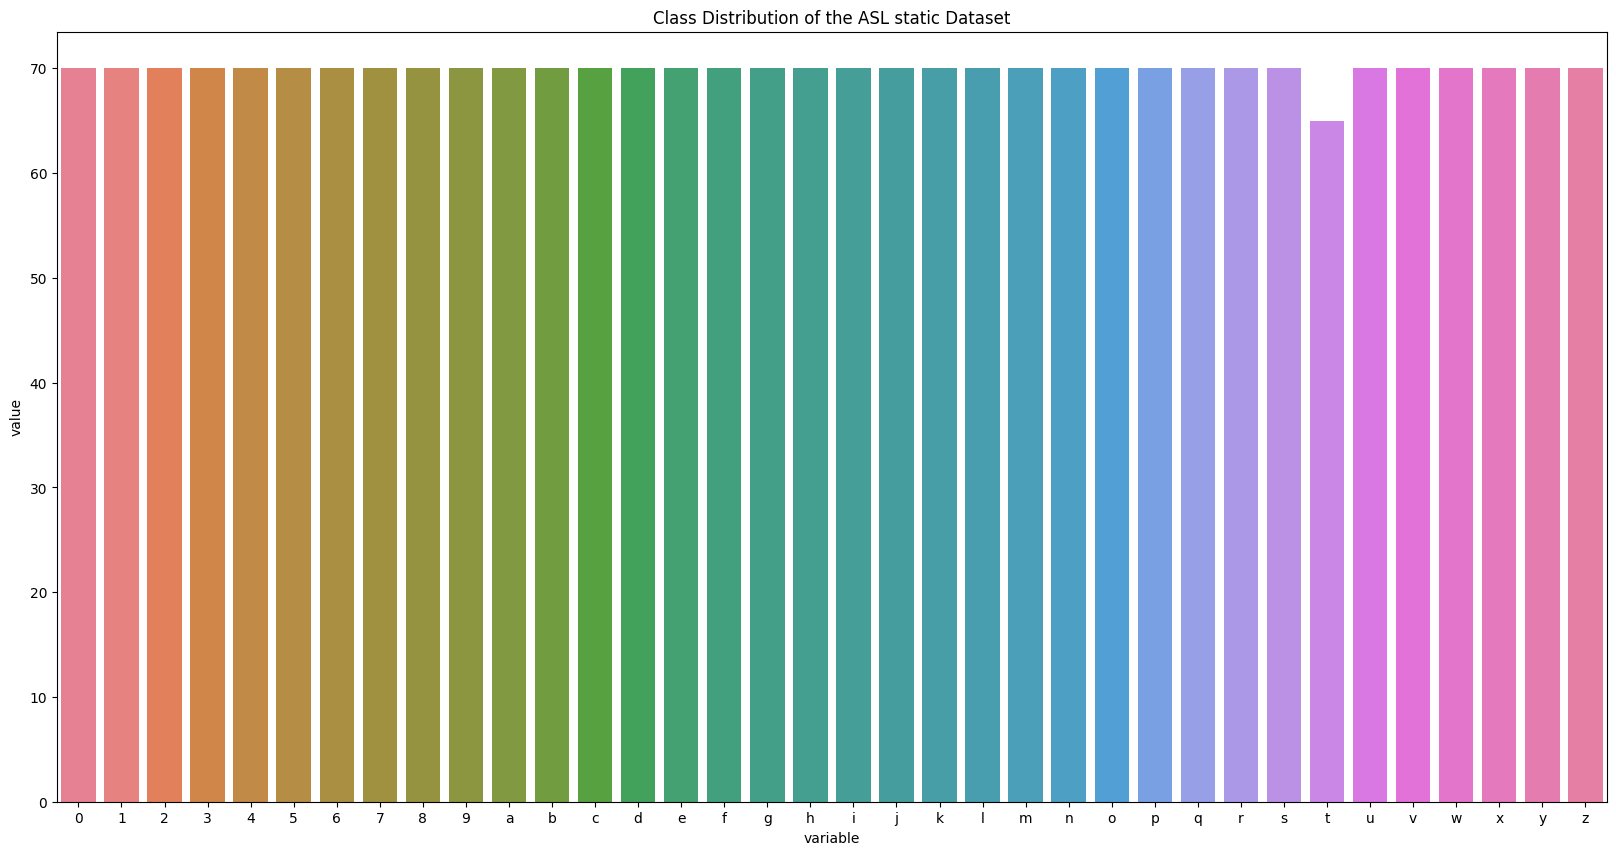

In [15]:
plt.figure(figsize=(20, 10))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dt)]).melt(), 
            x = "variable", y="value", hue="variable").set_title('Class Distribution of the ASL static Dataset')

In [16]:
train_dataset, val_dataset, test_dataset = random_split(dt, (1500, 500, 515))
print(len(dt)) # length of the dataset
print(len(train_dataset)) # length of the train division
print(len(val_dataset)) # length of the validation division
print(len(test_dataset)) # length of the test division


2515
1500
500
515


In [18]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=64, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=64)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=64)

print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))
print("Length of the test_loader:", len(test_loader))

Length of the train_loader: 23
Length of the val_loader: 8
Length of the test_loader: 9


Text(0.5, 1.0, 'Test Set')

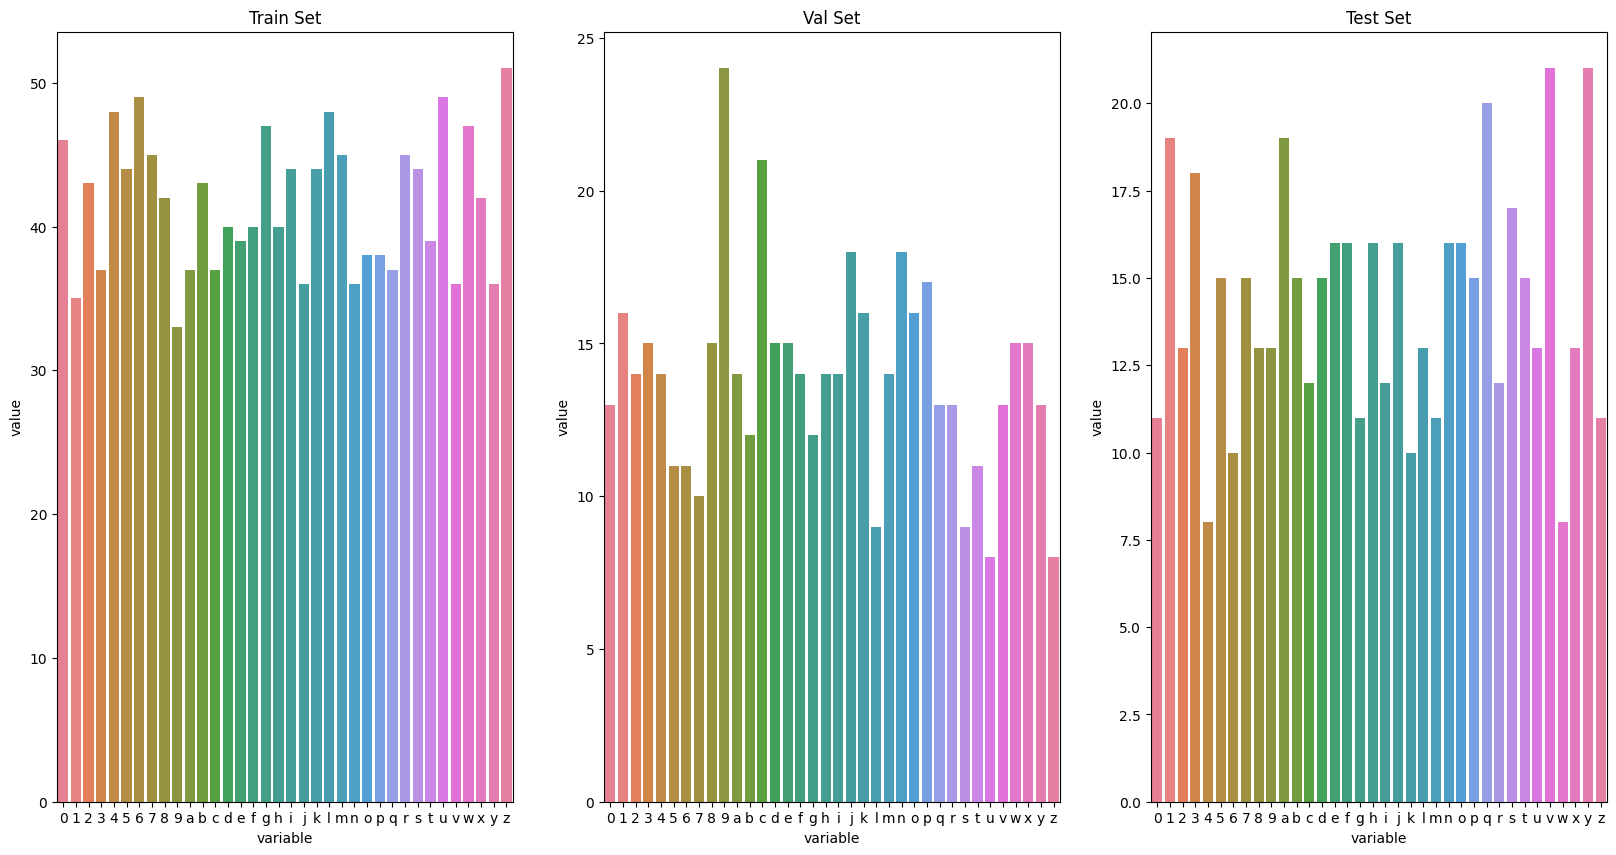

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_dataset)]).melt(),
            x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(val_dataset)]).melt(), 
            x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Val Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(test_dataset)]).melt(),
            x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Test Set')